# Preparing the dataset for hippocampus segmentation

In this notebook you will use the skills and methods that we have talked about during our EDA Lesson to prepare the hippocampus dataset using Python. Follow the Notebook, writing snippets of code where directed so using Task comments, similar to the one below, which expects you to put the proper imports in place. Write your code directly in the cell with TASK comment. Feel free to add cells as you see fit, but please make sure that code that performs that tasked activity sits in the same cell as the Task comment.


In [1]:
# TASK: Import the following libraries that we will use: nibabel, matplotlib, numpy
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import glob, os
from scipy import stats
import shutil

It will help your understanding of the data a lot if you were able to use a tool that allows you to view NIFTI volumes, like [3D Slicer](https://www.slicer.org/). I will refer to Slicer throughout this Notebook and will be pasting some images showing what your output might look like.

## Loading NIFTI images using NiBabel

NiBabel is a python library for working with neuro-imaging formats (including NIFTI) that we have used in some of the exercises throughout the course. Our volumes and labels are in NIFTI format, so we will use nibabel to load and inspect them.

NiBabel documentation could be found here: https://nipy.org/nibabel/

Our dataset sits in two directories - *images* and *labels*. Each image is represented by a single file (we are fortunate to have our data converted to NIFTI) and has a corresponding label file which is named the same as the image file.

Note that our dataset is "dirty". There are a few images and labels that are not quite right. They should be quite obvious to notice, though. The dataset contains an equal amount of "correct" volumes and corresponding labels, and you don't need to alter values of any samples in order to get the clean dataset.

In [2]:
# TASK: Your data sits in directory /data/TrainingSet.
# Load an image and a segmentation mask into variables called image and label
image = nib.load("/data/TrainingSet/images/hippocampus_001.nii.gz")
label = nib.load("/data/TrainingSet/labels/hippocampus_001.nii.gz")

image_data = image.get_fdata()
label_data = label.get_fdata()

image shape = (35, 51, 35), label shape = (35, 51, 35)


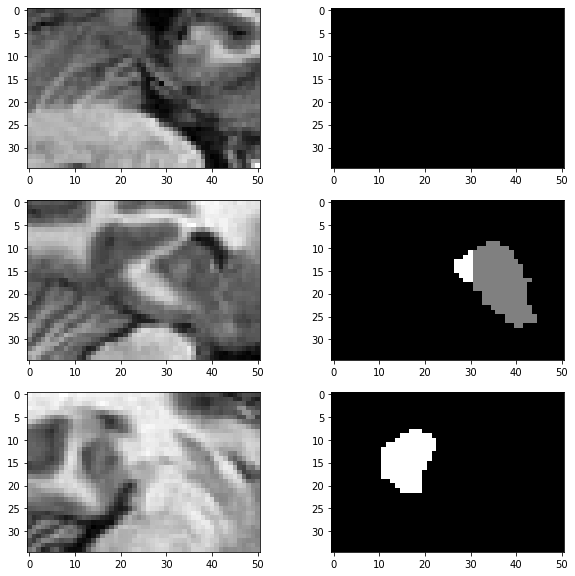

In [3]:
# Nibabel can present your image data as a Numpy array by calling the method get_fdata()
# The array will contain a multi-dimensional Numpy array with numerical values representing voxel intensities. 
# In our case, images and labels are 3-dimensional, so get_fdata will return a 3-dimensional array. You can verify this
# by accessing the .shape attribute. What are the dimensions of the input arrays?

# TASK: using matplotlib, visualize a few slices from the dataset, along with their labels. 
# You can adjust plot sizes like so if you find them too small:
plt.rcParams["figure.figsize"] = (10,10)
fig, axs = plt.subplots(3,2)

print(f"image shape = {image.shape}, label shape = {label.shape}")
for i in range(len(axs)):
    # note that the index plotted here are chosen arbitrarily
    axs[i][0].imshow(image_data[:,:,0+i*10], cmap="gray")
    axs[i][1].imshow(label_data[:,:,0+i*10], cmap="gray")

Load volume into 3D Slicer to validate that your visualization is correct and get a feel for the shape of structures.Try to get a visualization like the one below (hint: while Slicer documentation is not particularly great, there are plenty of YouTube videos available! Just look it up on YouTube if you are not sure how to do something)

![3D slicer](img/Slicer.png)

In [4]:
# Stand out suggestion: use one of the simple Volume Rendering algorithms that we've
# implemented in one of our earlier lessons to visualize some of these volumes
def display_volume_slices(img, w, h):
    plot_w = w
    plot_h = h

    # You can play with figsize parameter to adjust how large the images are
    fig, ax = plt.subplots(plot_h, plot_w, figsize=[35,35])

    for i in range(plot_w*plot_h):
        plt_x = i % plot_w
        plt_y = i // plot_w
        if (i < len(img)):
            ax[plt_y, plt_x].set_title(f"slice {i}")
            ax[plt_y, plt_x].imshow(img[:,:,i], cmap='gray')
        ax[plt_y, plt_x].axis("off")

    plt.show()

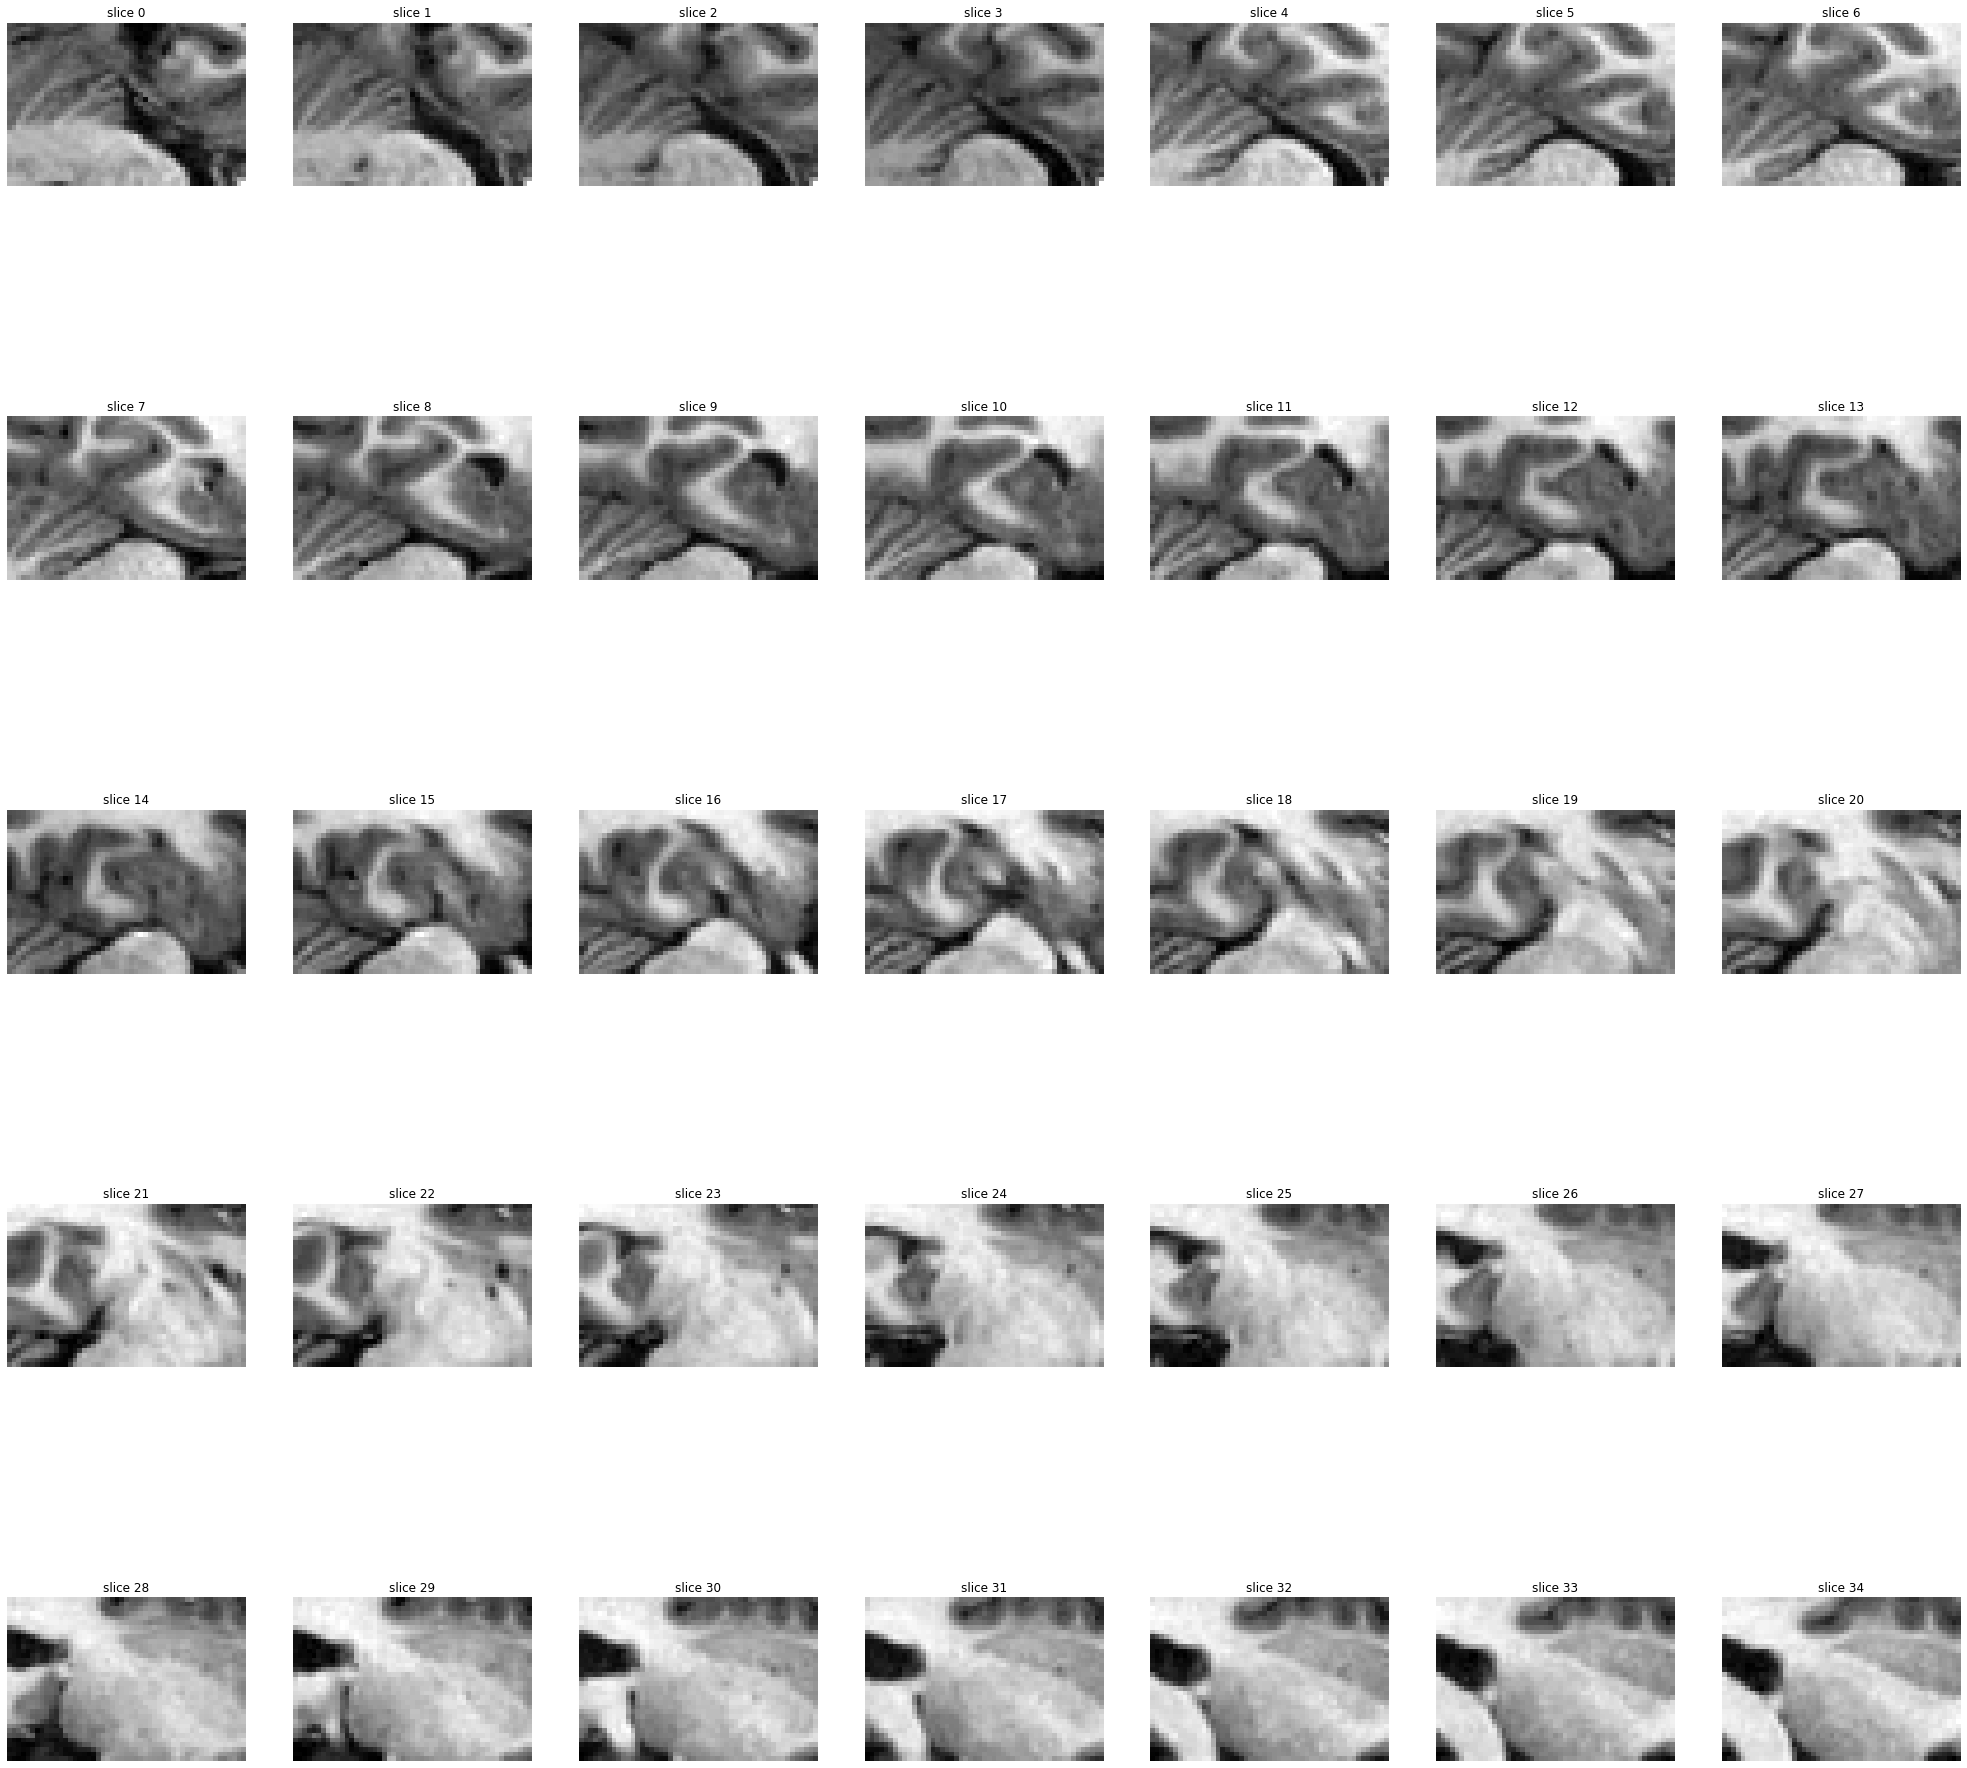

In [5]:
display_volume_slices(image_data, 7, 5)

## Looking at single image data
In this section we will look closer at the NIFTI representation of our volumes. In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world.

In [6]:
# Nibabel supports many imaging formats, NIFTI being just one of them. I told you that our images 
# are in NIFTI, but you should confirm if this is indeed the format that we are dealing with
# TASK: using .header_class attribute - what is the format of our images?

image.header_class
# Our images has the NIfTI1 image format

nibabel.nifti1.Nifti1Header

Further down we will be inspecting .header attribute that provides access to NIFTI metadata. You can use this resource as a reference for various fields: https://brainder.org/2012/09/23/the-nifti-file-format/

In [7]:
# TASK: How many bits per pixel are used?
image.header["bitpix"]

array(8, dtype=int16)

In [8]:
# TASK: What are the units of measurement?
units = image.header["xyzt_units"]
print(f"Spatial = {units & 0x7} Temporal = {((units >> 3) & 0x7) << 3}")
image.header["xyzt_units"]

# Spatial = 2 means Milimeter (mm)
# Temporal = 8 means Seconds (s)

Spatial = 2 Temporal = 8


array(10, dtype=uint8)

In [9]:
# TASK: Do we have a regular grid? What are grid spacings?
image.header["pixdim"]
# Yes, we have a regular grid of 1.0

array([1., 1., 1., 1., 1., 0., 0., 0.], dtype=float32)

In [10]:
# TASK: What dimensions represent axial, sagittal, and coronal slices? How do you know?
print(image.header["dim"])
print(image.header["srow_x"], image.header["srow_y"], image.header["srow_z"])
# It is coronal (image[i,:,:]), sagittal (image[:,i,:]), and axial (image[:,:,:])
# Confirmed with 3D Slicer, as well as srow_x, y, z which is an identity matrix (meaning no transpose needed, just direct x, y, z)

[ 3 35 51 35  1  1  1  1]
[1. 0. 0. 1.] [0. 1. 0. 1.] [0. 0. 1. 1.]


In [11]:
# By now you should have enough information to decide what are dimensions of a single voxel
# TASK: Compute the volume (in mm³) of a hippocampus using one of the labels you've loaded. 
# You should get a number between ~2200 and ~4500

# label_data contains values from 0 to 2. We're not gonna make a distinction between 1 and 2
# (ie, we assume that 2 or 1 = 1 mm^3).
print(f"Volume = {(label_data >= 1).sum()} mm^3") # mm^3

# We will be using the former to calculate volume

Volume = 2948 mm^3


## Plotting some charts

In [12]:
# putting the above volume calculator into a function
def compute_volume(lbl_data):
    return (lbl_data >= 1).sum()

[ 4001  4029  4030  4071  4074  4151  4263  4383  4401 20702]
[2382 2397 2416 2422 2448 2451 2471 2475 2532 2534]
2382 ModeResult(mode=array([3450]), count=array([3])) (262,)


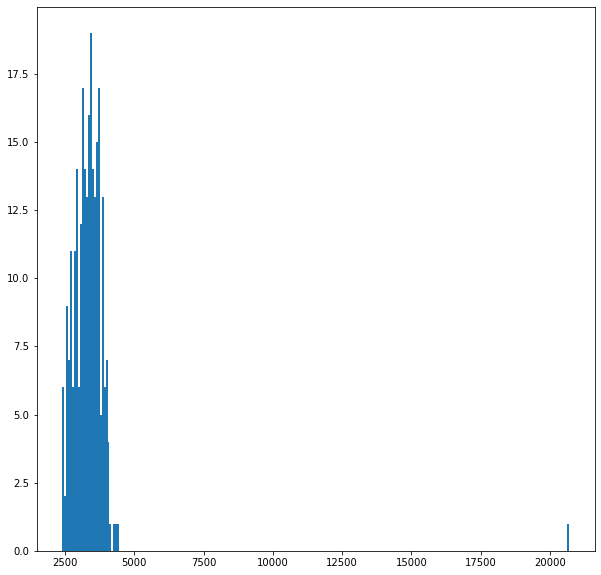

In [13]:
# TASK: Plot a histogram of all volumes that we have in our dataset and see how 
# our dataset measures against a slice of a normal population represented by the chart below.
mypath = '/data/TrainingSet/labels/'
paths = [os.path.join(mypath, x) for x in glob.glob(f"{mypath}*.nii.gz")]
labels = [nib.load(x) for x in paths]
volumes = np.array([compute_volume(x.get_fdata()) for x in labels])

plt.hist(volumes, bins=256)

volumes2 = volumes.copy()
volumes2.sort()
print(volumes2[-10:])
print(volumes2[:10])
print(np.min(volumes2), stats.mode(volumes2), volumes.shape)

# Excluding the outlier, the data has mode=3450, min = 2382 and max = 4401.
# The curve follows a normal distribution
# The curve is around 500 mm^3 lower than the average compared to the normal population at the chart below

(array([1., 1., 0., 0., 1., 1., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0.,
        0., 0., 3., 1., 0., 0., 1., 0., 0., 4., 0., 0., 2., 0., 2., 1., 1.,
        0., 1., 0., 2., 1., 1., 1., 1., 2., 1., 0., 2., 0., 3., 0., 1., 0.,
        1., 0., 0., 2., 1., 2., 0., 0., 0., 4., 2., 1., 0., 3., 0., 0., 1.,
        2., 2., 0., 5., 2., 0., 0., 1., 0., 1., 2., 0., 0., 2., 1., 1., 1.,
        1., 1., 0., 1., 2., 3., 2., 3., 0., 1., 1., 4., 2., 1., 3., 2., 0.,
        1., 3., 3., 1., 3., 1., 0., 2., 4., 0., 1., 0., 2., 2., 1., 1., 0.,
        3., 2., 1., 2., 2., 1., 4., 1., 0., 2., 1., 3., 3., 0., 3., 3., 3.,
        4., 0., 1., 2., 0., 1., 4., 1., 2., 0., 4., 0., 2., 1., 1., 2., 2.,
        1., 1., 3., 0., 4., 0., 2., 1., 2., 2., 3., 2., 2., 2., 2., 1., 2.,
        2., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 2., 2., 1., 1., 3., 1.,
        0., 1., 2., 0., 0., 0., 0., 1., 1., 0., 1., 2., 2., 0., 0., 2., 1.,
        2., 1., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
        0., 

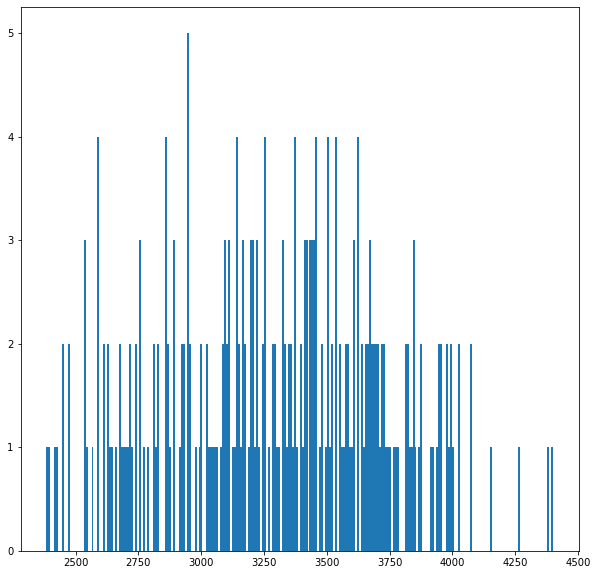

In [14]:
# removed outlier
volumes3 = volumes[volumes < 5000]
plt.hist(volumes3, bins=256)

<img src="img/nomogram_fem_right.svg" width=400 align=left>

Do you see any outliers? Why do you think it's so (might be not immediately obvious, but it's always a good idea to inspect) outliers closer. If you haven't found the images that do not belong, the histogram may help you.

In the real world we would have precise information about the ages and conditions of our patients, and understanding how our dataset measures against population norm would be the integral part of clinical validation that we talked about in last lesson. Unfortunately, we do not have this information about this dataset, so we can only guess why it measures the way it is. If you would like to explore further, you can use the [calculator from HippoFit project](http://www.smanohar.com/biobank/calculator.html) to see how our dataset compares against different population slices

Did you notice anything odd about the label files? We hope you did! The mask seems to have two classes, labeled with values `1` and `2` respectively. If you visualized sagittal or axial views, you might have gotten a good guess of what those are. Class 1 is the anterior segment of the hippocampus and class 2 is the posterior one. 

For the purpose of volume calculation we do not care about the distinction, however we will still train our network to differentiate between these two classes and the background

In [15]:
# TASK: Copy the clean dataset to the output folder inside section1/out. You will use it in the next Section
if os.path.exists('/home/workspace/out/images'):
    shutil.rmtree('/home/workspace/out/images')
if os.path.exists('/home/workspace/out/labels'):
    shutil.rmtree('/home/workspace/out/labels')
shutil.copytree('/data/TrainingSet/images/', '/home/workspace/out/images')
shutil.copytree('/data/TrainingSet/labels/', '/home/workspace/out/labels')
    
print("Outlier Data:")
print("Volume too big:")
for i in np.where(volumes > 4500):
    print(i, paths[i[0]])
    dst_path = os.path.join('/home/workspace/out/images', os.path.basename(paths[i[0]]))
    os.remove(dst_path)
    dst_path = os.path.join('/home/workspace/out/labels', os.path.basename(paths[i[0]]))
    os.remove(dst_path)

print("File size too big:")
# also remove files that are weird very large (ie, not cropped)
for i in glob.glob("/home/workspace/out/images/*.nii.gz"):
    if os.path.getsize(i) > 200000:
        print(i)
        dst_path = os.path.join('/home/workspace/out/images', os.path.basename(i))
        os.remove(dst_path)
        dst_path = os.path.join('/home/workspace/out/labels', os.path.basename(i))
        os.remove(dst_path)

print("Label does not exist:")
for i in glob.glob("/home/workspace/out/images/*.nii.gz"):
    dst_path = os.path.join('/home/workspace/out/labels', os.path.basename(i))
    if not os.path.exists(dst_path):
        print(i)
        os.remove(i)

Outlier Data:
Volume too big:
[200] /data/TrainingSet/labels/hippocampus_281.nii.gz
File size too big:
/home/workspace/out/images/hippocampus_010.nii.gz
Label does not exist:
/home/workspace/out/images/hippocampus_118.nii.gz


## Final remarks

Congratulations! You have finished Section 1. 

In this section you have inspected a dataset of MRI scans and related segmentations, represented as NIFTI files. We have visualized some slices, and understood the layout of the data. We have inspected file headers to understand what how the image dimensions relate to the physical world and we have understood how to measure our volume. We have then inspected dataset for outliers, and have created a clean set that is ready for consumption by our ML algorithm. 

In the next section you will create training and testing pipelines for a UNet-based machine learning model, run and monitor the execution, and will produce test metrics. This will arm you with all you need to use the model in the clinical context and reason about its performance!